# Preprocessing #
Evan Petrimoulx\
Sania Palaha\
Data Analytics 1

In [1]:
import os
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from skimage import color
from matplotlib.image import imread
from numpy.fft import fft2, fftshift
from scipy.fft import fftshift

In [2]:
image_pixel_array = [] 
filename = []
Type = []
is_healthy = []
for folder in os.listdir('Plant_leave_diseases_dataset_without_augmentation'):
    if folder.endswith(".DS_Store"):
        continue
    for file in os.listdir('Plant_leave_diseases_dataset_without_augmentation/' + folder):
        if file.endswith(".jpg"):
            filename.append(file)
            image = imread('Plant_leave_diseases_dataset_without_augmentation/' + folder + '/' + file)
            image_pixel_array.append(image)
        if "___healthy" in folder:
            is_healthy.append(True)
            Type.append("None")
        else:
            is_healthy.append(False)
            Type.append(folder.partition("___")[2])
   
         
image_pixel_array = np.array(image_pixel_array)

Dataset is now loaded and stored as a 3D numpy array (image, (horizontal pixels, vertical pixels)). Now we can perform the data preprocessing, and store the dataset.

### Fourier Transform Feature ###

(1500, 256, 256, 3)


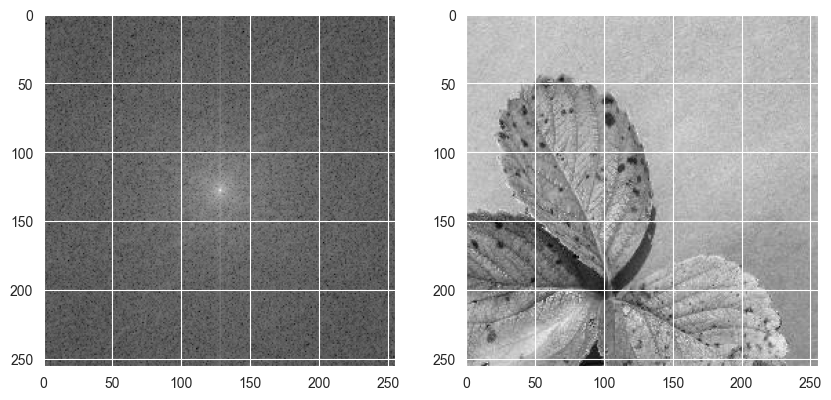

In [3]:
# Fourier Transform Information
Fourier_Data = []
Fourier_Data_Real = []
Fourier_Data_Imag = []
mean_frequency = []
variance_frequency = []
num_images = image_pixel_array.shape[0]

print(image_pixel_array.shape)

for image in range(num_images):
    grayscale_image = color.rgb2gray(image_pixel_array[image]) # Convert to greyscale
    image_FT = fftshift(fft2(fftshift(grayscale_image))) # Compute 2D Fourier Transform
    Fourier_Data.append(image_FT)    
    mean_frequency.append(Fourier_Data[image].mean())
    variance_frequency.append(np.var(Fourier_Data[image]))
    
Fourier_Data_Real = np.real(Fourier_Data)
Fourier_Data_Imag = np.imag(Fourier_Data)
mean_frequency_real = np.real(mean_frequency)
mean_frequency_imaginary = np.imag(mean_frequency)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(Fourier_Data[-1])), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(grayscale_image, cmap='gray')
plt.show()

### Contrast Enhancement ###

(1500, 256, 256, 3)


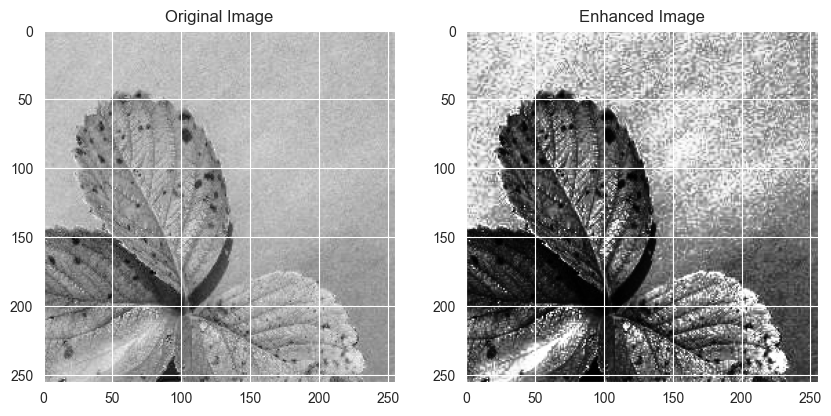

In [4]:
# Using CLAHE - Adaptive Histogram Equalization
enhanced_images = []
contrast_std = []
min_intensity = []
max_intensity = []
num_images = image_pixel_array.shape[0]

print(image_pixel_array.shape)

for image in range(num_images):
    grayscale_image = color.rgb2gray(image_pixel_array[image]) # Convert to greyscale
    enhanced_image = cv.equalizeHist((grayscale_image * 255).astype(np.uint8)) # Enhance contrast by applying histogram equalization
    enhanced_images.append(enhanced_image) # Append enhanced image to list
    contrast_std.append(np.std(grayscale_image))
    min_intensity.append(np.min(grayscale_image))
    max_intensity.append(np.max(grayscale_image))
    
    

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(grayscale_image, cmap='gray') # Show original grayscale image
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(enhanced_images[-1], cmap='gray') # Show contrast-enhanced image
plt.title("Enhanced Image")
plt.show()

### Noise Reduction ###

(1500, 256, 256, 3)


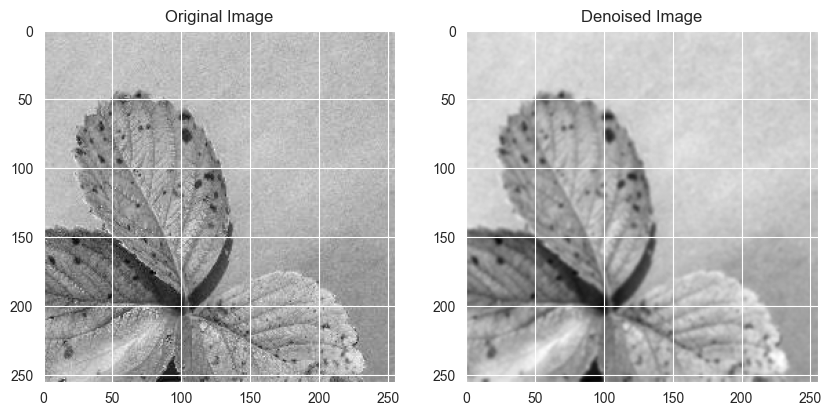

In [5]:
denoised_images = []
mean_noise = []
std_noise = []
num_images = image_pixel_array.shape[0]

print(image_pixel_array.shape)

for image in range(num_images):
    grayscale_image = color.rgb2gray(image_pixel_array[image]) # Convert to greyscale
    denoised_image = cv.GaussianBlur(grayscale_image, (5, 5), 0) # Apply Gaussian blur for noise reduction
    denoised_images.append(denoised_image) # Append denoised image to list
    mean_noise.append(np.mean(grayscale_image))
    std_noise.append(np.std(grayscale_image))
    

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(grayscale_image, cmap='gray') # Show original grayscale image
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(denoised_images[-1], cmap='gray') # Show denoised image
plt.title("Denoised Image")
plt.show()

### Edge Detection ###

(1500, 256, 256, 3)


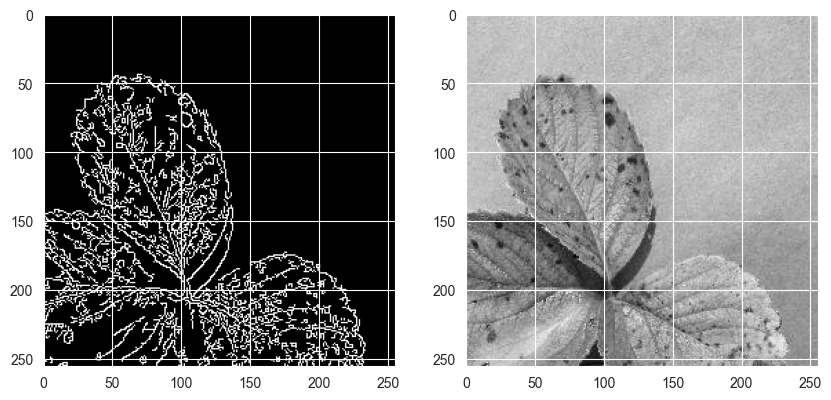

In [6]:
Edges = []
num_edges = []
num_images = image_pixel_array.shape[0]

print(image_pixel_array.shape)

for image in range(num_images):
    gray_image = color.rgb2gray(image_pixel_array[image])  # Convert to grayscale
    gray_image = (gray_image * 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
    edges = cv.Canny(gray_image, 100, 220)
    Edges.append(edges)  
    num_edges.append(np.sum(edges > 0))

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(Edges[-1], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.show()

### Combining Into Overall Dataframe ###

In [7]:
Plant_Data = []

for image in range(num_images):
    Plant_Data.append([
        filename[image],
        num_edges[image],
        mean_frequency_real[image],
        mean_frequency_imaginary[image],
        variance_frequency[image],
        contrast_std[image],
        mean_noise[image],
        std_noise[image],
        min_intensity[image],
        max_intensity[image],
        is_healthy[image],
        Type[image],
    ])

feature_names = ['Image', 'Edge_Count', 'Re(Mean_Frequency)', 'Im(Mean_Frequency)', 'Frequency_Variance', 'StDev_Contrast', 'Mean_Noise', 'StDev_Noise', 'Minimum_Intensity', 'Maximum_Intensity', 'Is_Healthy', 'Disease']

Plant_Dataset = pd.DataFrame(Plant_Data, columns=feature_names)
Plant_Dataset.to_csv('Feature_Extracted_Plant_Dataset.csv', index=False)

In [8]:
Plant_Dataset.describe()

,Edge_Count,Re(Mean_Frequency),Im(Mean_Frequency),Frequency_Variance,StDev_Contrast,Mean_Noise,StDev_Noise,Minimum_Intensity,Maximum_Intensity
count,1500.000000,1.500000e+03,1.500000e+03,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,3733.535333,5.989650e-01,-5.655018e-19,22014.959039,0.130521,0.536565,0.130521,0.145936,0.956581
std,3703.635039,1.935199e-01,2.498024e-17,9643.229257,0.042781,0.170824,0.042781,0.128510,0.081043
min,0.000000,2.287667e-17,-1.023487e-16,767.239036,0.039815,0.032910,0.039815,0.000000,0.512022
25%,880.750000,4.726469e-01,-1.517883e-17,15588.933324,0.099020,0.471818,0.099020,0.042561,0.957370
50%,2208.000000,6.035386e-01,-3.252607e-19,22965.973814,0.123368,0.574923,0.123368,0.112293,0.994167
75%,5652.250000,7.168188e-01,1.507041e-17,29156.339680,0.155001,0.654635,0.155001,0.225440,1.000000
max,19455.000000,1.000000e+00,1.179612e-16,45719.011444,0.329416,0.832021,0.329416,0.594200,1.000000


In [9]:
Plant_Dataset

,Image,Edge_Count,Re(Mean_Frequency),Im(Mean_Frequency),Frequency_Variance,StDev_Contrast,Mean_Noise,StDev_Noise,Minimum_Intensity,Maximum_Intensity,Is_Healthy,Disease
0,image (263).jpg,1111,0.484367,-2.818926e-18,1701.684807,0.144301,0.071738,0.144301,0.000000,0.769722,True,None
1,image (799).jpg,1476,0.374271,5.366801e-17,5247.412525,0.228525,0.166876,0.228525,0.000000,0.813731,True,None
2,image (1385).jpg,1749,0.304890,3.632077e-17,6443.700026,0.251777,0.186903,0.251777,0.000000,0.957362,True,None
3,image (1405).jpg,3357,0.427836,2.255141e-17,6961.454301,0.269340,0.183527,0.269340,0.000000,0.984315,True,None
4,image (388).jpg,1210,0.451401,-8.673617e-18,3356.495539,0.191576,0.120490,0.191576,0.000000,0.708468,True,None
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,image (1772).jpg,3122,0.728791,1.864828e-17,28356.807145,0.086109,0.652138,0.086109,0.162585,0.987842,False,Black_rot
1496,image (892).jpg,6965,0.555556,6.938894e-18,15556.956061,0.096675,0.477534,0.096675,0.120117,0.980223,False,Black_rot
1497,image (780).jpg,13604,0.531126,6.938894e-18,27712.195356,0.108694,0.641127,0.108694,0.181121,0.994077,False,Black_rot
1498,image (372).jpg,4830,0.421178,2.255141e-17,26638.859475,0.092776,0.630771,0.092776,0.167936,0.987366,False,Black_rot
